#Librerias

In [1]:
!pip install opencv-python # Instala la librería OpenCV para procesamiento de imágenes
!pip install keras-tuner # Se utiliza para realizar búsqueda automática de hiperparámetros en modelos Keras/TensorFlow.
!pip install --quiet optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 10.8 MB/s eta 0:00:00


In [2]:
# Librerías del sistema y manejo de archivos
import os
import sys
from os import listdir
from os.path import join

# Librerías para uso en Google Colab
from google.colab import drive

# Librerías para procesamiento numérico y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

# Librerías para procesamiento y lectura de imágenes
import cv2

# Librerías para machine learning
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import keras_tuner as kt

# Librerías para deep learning
import tensorflow as tf
from tensorflow.keras.metrics import Recall, AUC
from tensorflow.keras.callbacks import ModelCheckpoint ## guardar mejor modelo
from sklearn.metrics import roc_auc_score
import optuna

# Librerías para utilidades adicionales
from tqdm import tqdm  # barra de progreso
import joblib  # para guardar/cargar objetos como modelos o arrays

# Conectar con google drive

In [3]:
# conectar con Google Drive para acceder a archivos desde Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path="/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones" ### ruta del repositorio en drive
os.chdir(path) ### volver la carpeta del repositorio directorio de trabajo
sys.path.append(path) ### agregarla al path, poder leer archivos de funciones propios como paquetes

In [5]:
import _funciones as fn #Llamar el archivo de funciones de este proyecto

# Carga de datos procesados

array([[[244, 164, 175],
        [241, 161, 172],
        [243, 162, 171],
        ...,
        [245, 165, 178],
        [241, 163, 176],
        [238, 160, 173]],

       [[244, 163, 171],
        [242, 161, 169],
        [242, 160, 170],
        ...,
        [243, 163, 176],
        [241, 161, 174],
        [238, 158, 171]],

       [[238, 156, 162],
        [239, 158, 164],
        [240, 159, 166],
        ...,
        [242, 162, 175],
        [240, 160, 173],
        [239, 159, 172]],

       ...,

       [[225, 155, 147],
        [226, 155, 148],
        [229, 158, 152],
        ...,
        [223, 150, 157],
        [226, 155, 161],
        [225, 154, 160]],

       [[224, 156, 147],
        [227, 159, 150],
        [228, 159, 152],
        ...,
        [223, 151, 155],
        [227, 156, 160],
        [227, 156, 159]],

       [[226, 158, 149],
        [226, 158, 150],
        [227, 158, 151],
        ...,
        [225, 153, 157],
        [225, 154, 158],
        [223, 152, 156]]], dtype=uint8)
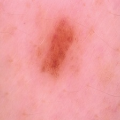

In [6]:
# Cargar los conjuntos de entrenamiento y prueba ya procesados

x_train = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/X_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/X_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/y_test.pkl')

x_train[0] # Muestra la primera imagen del conjunto de entrenamiento

## Preprocesamiento de datos

In [7]:
# Convertir a tipo float para escalar
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [8]:
x_train.max() # Ver valor máximo
x_train.min() # Ver valor mínimo

np.float32(0.0)

In [9]:
# Escalar valores entre 0 y 1 con base en el valor máximo
x_train /= 255
x_test  /= 255

In [10]:
# Verificar dimensiones
x_train.shape
x_test.shape

# Número de variables por imagen
np.prod(x_train[1].shape)

# Ver distribución de clases
np.unique(y_train, return_counts=True)
np.unique(y_test, return_counts=True)

(array([0, 1]), array([322, 258]))

In [11]:
x_train.shape

(2317, 120, 120, 3)

In [12]:
x_test.shape

(580, 120, 120, 3)

In [13]:
y_train.shape

(2317, 1)

In [14]:
y_test.shape

(580, 1)

# Modelo de red convolucional simple

In [15]:
# Modelo secuencial, capas apiladas una tras otra
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]), #Capa convolucional 16
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'), #Capa convolucional 32
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'), #Capa convolucional 64
    tf.keras.layers.Dense(1, activation='sigmoid')  # Capa de salida para clasificación binaria (0 o 1) con activación sigmoid
])

#Compilar el modelo con  binary cross-entropy y optimizador de Adam
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC', 'Recall', 'Precision'])

checkpoint = ModelCheckpoint(
    filepath='Salidas/best_cnn_auc.keras',
    monitor='val_AUC',        # Metric must match name used in model.compile()
    mode='max',               # Use 'max' because higher AUC is better
    save_best_only=True,
    verbose=1
)

# Entrenar el modelo
cnn_model.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test), callbacks=checkpoint)

# Resumen del modelo
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.5669 - Precision: 0.5731 - Recall: 0.3926 - accuracy: 0.5672 - loss: 1.5211
Epoch 1: val_AUC improved from -inf to 0.80903, saving model to Salidas/best_cnn_auc.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - AUC: 0.5685 - Precision: 0.5723 - Recall: 0.3945 - accuracy: 0.5681 - loss: 1.5005 - val_AUC: 0.8090 - val_Precision: 0.6799 - val_Recall: 0.7326 - val_accuracy: 0.7276 - val_loss: 0.5466
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.8024 - Precision: 0.6722 - Recall: 0.6920 - accuracy: 0.7147 - loss: 0.5373
Epoch 2: val_AUC improved from 0.80903 to 0.85388, saving model to Salidas/best_cnn_auc.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - AUC: 0.8033 - Precision: 0.6734 - Recall: 0.6929 - accuracy: 0.7155 - loss: 0.5361 - val_AUC: 0.8539 - val_Precision: 0.7697 - val_Recall: 0.4535 - val_accuracy: 0.6966 - val_loss: 0.5199
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.8581 - Precision: 0.7313 - Reca

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,326,533 (73.72 MB)

 Trainable params: 6,442,177 (24.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,884,356 (49.15 MB)

In [16]:
cnn_best_auc=tf.keras.models.load_model('Salidas/best_cnn_auc.keras')
test_loss_m1, test_acc_m1, test_auc_m1, test_recall_m1, test_precision_m1 = cnn_best_auc.evaluate(x_test, y_test, verbose=2)
print("\n### Resultados Red Convolucional Simple maximizando el AUC ###")
print("Test Accuracy:", test_acc_m1)
print("Test AUC:", test_auc_m1)
print("Test Recall:", test_recall_m1)
print("Test Precision:", test_precision_m1)

19/19 - 4s - 236ms/step - AUC: 0.9319 - Precision: 0.8912 - Recall: 0.6667 - accuracy: 0.8155 - loss: 0.3583

### Resultados Red Convolucional Simple maximizando el AUC ###
Test Accuracy: 0.815517246723175
Test AUC: 0.9319177269935608
Test Recall: 0.6666666865348816
Test Precision: 0.8911917209625244


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       322
           1       0.87      0.74      0.80       258

    accuracy                           0.83       580
   macro avg       0.84      0.82      0.83       580
weighted avg       0.84      0.83      0.83       580



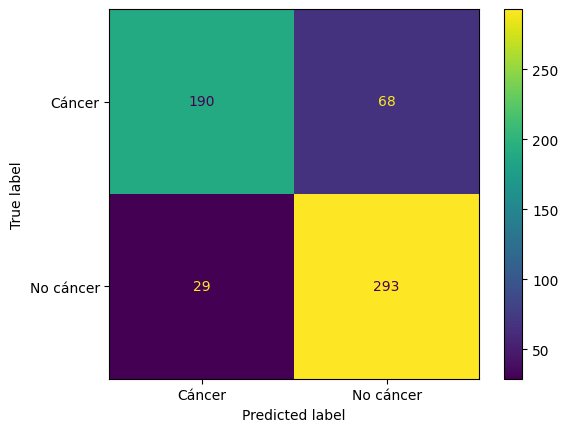

In [17]:
pred_test = (cnn_best_auc.predict(x_test) > 0.45).astype('int') # Predecir y aplicar umbral de 0.5 para convertir a clase 0 o 1
cm = metrics.confusion_matrix(y_test, pred_test, labels=[1, 0])  # Calcular matriz de confusión
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=['Cáncer', 'No cáncer']) # para visualizacion de matriz de confusion
disp.plot()

print(metrics.classification_report(y_test, pred_test)) # reporte con precisión, recall y f1-score

# Afinamiento de hiperparametros

##Hiperparámetros para mejorar el rendimiento en entrenamiento

In [18]:
# Función objetivo para utilizar optuna
def objective(trial):
    # grilla de huiperparámetros
    kernel_size = trial.suggest_int('kernel_size', 3, 6, step=1)
    dense_units = trial.suggest_int('dense_units', 64, 256,step=32)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd'])

    # Build the model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(kernel_size, kernel_size), activation='relu', input_shape=x_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    checkpoint3 = ModelCheckpoint(
    filepath='/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras',
    monitor='val_auc',        # Metric must match name used in model.compile()
    mode='max',               # Use 'max' because higher AUC is better
    save_best_only=True,
    verbose=1)

    #Choose optimizer
    if optimizer_name == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=0.001)

    # Compile with AUC metric
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC(name='auc')]) #opt

    # Train the model
    history= model.fit(
            x_train, y_train,
            epochs=5,
            validation_data=(x_test, y_test),
            batch_size=100,
            verbose=0,
            callbacks=checkpoint3
        )
    model_win=tf.keras.models.load_model('Salidas/best_cnn_optuna.keras')

    # Predict probabilities and compute AUC manually
    y_pred_prob = model_win.predict(x_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)

    # Save best model in trial attributes
    trial.set_user_attr("model", model_win)

    return auc

In [19]:
# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

# Get best model
best_trial = study.best_trial
best_model = best_trial.user_attrs["model"]

# Final evaluation
test_loss_m3, test_auc_m3 = best_model.evaluate(x_test, y_test)
print(f"\Mejor AUC on test set: {test_auc_m3:.4f}")
best_model.summary()

[I 2025-05-30 22:24:44,843] A new study created in memory with name: no-name-7493caf9-8458-47a7-8123-42b61bf051c6
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_auc improved from -inf to 0.67444, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 2: val_auc improved from 0.67444 to 0.73886, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 3: val_auc improved from 0.73886 to 0.78597, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 4: val_auc improved from 0.78597 to 0.83846, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 5: val_auc improved from 0.83846 to 0.84100, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step


[I 2025-05-30 22:31:02,823] Trial 0 finished with value: 0.8426862150320189 and parameters: {'kernel_size': 4, 'dense_units': 256, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.8426862150320189.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_auc improved from -inf to 0.83605, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 2: val_auc improved from 0.83605 to 0.89314, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 3: val_auc improved from 0.89314 to 0.90607, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 4: val_auc improved from 0.90607 to 0.90635, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 5: val_auc improved from 0.90635 to 0.91765, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step


[I 2025-05-30 22:37:33,472] Trial 1 finished with value: 0.9177981607203043 and parameters: {'kernel_size': 4, 'dense_units': 224, 'optimizer': 'adam'}. Best is trial 1 with value: 0.9177981607203043.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_auc improved from -inf to 0.68326, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 2: val_auc improved from 0.68326 to 0.71941, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 3: val_auc improved from 0.71941 to 0.76772, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 4: val_auc did not improve from 0.76772

Epoch 5: val_auc improved from 0.76772 to 0.80428, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step


[I 2025-05-30 22:44:17,226] Trial 2 finished with value: 0.8072367470749675 and parameters: {'kernel_size': 5, 'dense_units': 192, 'optimizer': 'sgd'}. Best is trial 1 with value: 0.9177981607203043.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_auc improved from -inf to 0.89336, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 2: val_auc did not improve from 0.89336

Epoch 3: val_auc did not improve from 0.89336

Epoch 4: val_auc improved from 0.89336 to 0.90535, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 5: val_auc improved from 0.90535 to 0.91450, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step


[I 2025-05-30 22:51:22,951] Trial 3 finished with value: 0.9145962732919255 and parameters: {'kernel_size': 5, 'dense_units': 224, 'optimizer': 'adam'}. Best is trial 1 with value: 0.9177981607203043.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_auc improved from -inf to 0.79609, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 2: val_auc did not improve from 0.79609

Epoch 3: val_auc improved from 0.79609 to 0.83259, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 4: val_auc improved from 0.83259 to 0.85143, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 5: val_auc improved from 0.85143 to 0.85251, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step


[I 2025-05-30 22:58:20,935] Trial 4 finished with value: 0.856625258799172 and parameters: {'kernel_size': 3, 'dense_units': 192, 'optimizer': 'sgd'}. Best is trial 1 with value: 0.9177981607203043.


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - auc: 0.9126 - loss: 0.3883
\Mejor AUC on test set: 0.9177


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 117, 117, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 58, 58, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 224)            │    11,239,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,779,813 (128.86 MB)

 Trainable params: 11,259,937 (42.95 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,519,876 (85.91 MB)

In [32]:
#Imprime el mejor AUC
print(f"\Mejor AUC on test set: {test_auc_m3:.4f}")

\Mejor AUC on test set: 0.9177


In [20]:
best_params = study.best_trial.params
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'kernel_size': 4, 'dense_units': 224, 'optimizer': 'adam'}


## Hiperparámetros para optimizar regulación y dropout

In [28]:
# Función objetivo para utilizar optuna
def objective(trial):
    # grilla de huiperparámetros
    dropout_rate =  trial.suggest_float('DO', 0.0 , 0.5,step=0.05) # Tasa de dropout: 5% a 20%
    reg_strength =  trial.suggest_float("rs", 0.0, 1.05,step=0.0001) # Fuerza de regularización L2
    optimizer_name =  trial.suggest_categorical('optimizer', ['adam', 'sgd']) # Optimizador a usar
    # Build the model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:], kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    checkpoint4 = ModelCheckpoint(
    filepath='/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras',
    monitor='val_auc',        # Metric must match name used in model.compile()
    mode='max',               # Use 'max' because higher AUC is better
    save_best_only=True,
    verbose=1)

    # Choose optimizer
    if optimizer_name == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=0.001)

    # Compile with AUC metric
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC(name='auc')])

    # Train the model
    history= model.fit(
            x_train, y_train,
            epochs=5,
            validation_data=(x_test, y_test),
            batch_size=100,
            verbose=0,
            callbacks=checkpoint4
        )

    model_win=tf.keras.models.load_model('Salidas/best_cnn_optuna2.keras')

    # Predict probabilities and compute AUC manually
    y_pred_prob = model_win.predict(x_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)

    # Save best model in trial attributes
    trial.set_user_attr("model", model_win)
    return auc

In [29]:
# Run the optimization
study2 = optuna.create_study(direction="maximize")
study2.optimize(objective, n_trials=5)

# Get best model
best_trial2 = study2.best_trial
best_model2 = best_trial2.user_attrs["model"]

# Final evaluation
test_loss_m4, test_auc_m4 = best_model2.evaluate(x_test, y_test)
print(f"\Mejor AUC on test set: {test_auc_m4:.4f}")
best_model2.summary()

[I 2025-05-31 00:28:10,898] A new study created in memory with name: no-name-4e6260d3-6cf7-4a9d-b601-3e2e958a1046
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_auc improved from -inf to 0.67169, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 2: val_auc improved from 0.67169 to 0.77868, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 3: val_auc improved from 0.77868 to 0.79753, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 4: val_auc did not improve from 0.79753

Epoch 5: val_auc did not improve from 0.79753
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step


[I 2025-05-31 00:34:51,026] Trial 0 finished with value: 0.7975167316673888 and parameters: {'DO': 0.05, 'rs': 0.2519, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7975167316673888.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_auc improved from -inf to 0.73918, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 2: val_auc improved from 0.73918 to 0.75321, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 3: val_auc did not improve from 0.75321

Epoch 4: val_auc improved from 0.75321 to 0.75539, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 5: val_auc did not improve from 0.75539
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step


[I 2025-05-31 00:41:30,000] Trial 1 finished with value: 0.7630844046415332 and parameters: {'DO': 0.45, 'rs': 0.5424, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7975167316673888.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_auc improved from -inf to 0.78228, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 2: val_auc improved from 0.78228 to 0.80707, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 3: val_auc improved from 0.80707 to 0.80853, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 4: val_auc improved from 0.80853 to 0.81935, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 5: val_auc improved from 0.81935 to 0.82350, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step


[I 2025-05-31 00:48:25,618] Trial 2 finished with value: 0.8267730752563918 and parameters: {'DO': 0.1, 'rs': 0.9695, 'optimizer': 'sgd'}. Best is trial 2 with value: 0.8267730752563918.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_auc improved from -inf to 0.75445, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 2: val_auc improved from 0.75445 to 0.77245, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 3: val_auc improved from 0.77245 to 0.78956, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 4: val_auc improved from 0.78956 to 0.80800, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 5: val_auc improved from 0.80800 to 0.81180, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step


[I 2025-05-31 00:55:02,967] Trial 3 finished with value: 0.8191053974673792 and parameters: {'DO': 0.05, 'rs': 0.8771, 'optimizer': 'sgd'}. Best is trial 2 with value: 0.8267730752563918.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_auc improved from -inf to 0.70383, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 2: val_auc improved from 0.70383 to 0.78227, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 3: val_auc did not improve from 0.78227

Epoch 4: val_auc did not improve from 0.78227

Epoch 5: val_auc did not improve from 0.78227
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 275ms/step


[I 2025-05-31 01:01:27,839] Trial 4 finished with value: 0.7902884106119699 and parameters: {'DO': 0.2, 'rs': 0.8482000000000001, 'optimizer': 'adam'}. Best is trial 2 with value: 0.8267730752563918.


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - auc: 0.8317 - loss: 185.4824
\Mejor AUC on test set: 0.8235


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 118, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,442,179 (24.57 MB)

 Trainable params: 6,442,177 (24.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [30]:
#Imprime el mejor AUC
print(f"\Mejor AUC on test set: {test_auc_m4:.4f}")

\Mejor AUC on test set: 0.8235


In [31]:
best_params = study2.best_trial.params
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'DO': 0.1, 'rs': 0.9695, 'optimizer': 'sgd'}


Con la optimización de hiperparametros el modelo empeora


#Resumen de indicadores

In [33]:
# Crear DataFrame con los resultados
resultados = pd.DataFrame({
    "Modelo": ["CNN Simple", "CNN con afinamiento de hiperparámetros"], # Nombres de los modelos
    "AUC": [test_auc_m1,test_auc_m3], # metricas auc de todos los modelos
    "Recall": [test_recall_m1,'NaN'] #metricas recall de todos los modelos
})

# Mostrar la tabla ordenada por AUC de mayor a menor
resultados = resultados.sort_values(by="AUC", ascending=False)

# Mostrar tabla sin índice
print(tabulate(resultados, headers='keys', tablefmt='fancy_grid', showindex=False))

╒════════════════════════════════════════╤══════════╤════════════╕
│ Modelo                                 │      AUC │     Recall │
╞════════════════════════════════════════╪══════════╪════════════╡
│ CNN Simple                             │ 0.931918 │   0.666667 │
├────────────────────────────────────────┼──────────┼────────────┤
│ CNN con afinamiento de hiperparámetros │ 0.917654 │ nan        │
╘════════════════════════════════════════╧══════════╧════════════╛


En esta segunda tabla se presentan tres variantes de redes neuronales convolucionales (CNN), entrenadas específicamente para procesar imágenes de manchas en la piel, con el objetivo de clasificar si son benignas o malignas. Estas arquitecturas fueron evaluadas con dos métricas fundamentales: AUC y Recall.

El modelo de CNN Simple obtuvo un AUC de 0.9114, el valor más alto entre todos los modelos evaluados, lo que indica una excelente capacidad para diferenciar entre casos de cáncer y casos benignos. Su recall fue de 0.9031, también elevado, lo que refleja una buena capacidad para identificar correctamente los casos positivos.

El modelo de CNN con regularizador L2 y Dropout alcanzó un AUC de 0.8480 y un recall de 0.8915. Aunque su AUC es inferior al del modelo simple, su valor de recall sigue siendo muy alto, lo cual es crucial en contextos médicos, ya que implica una baja tasa de falsos negativos.

Por otro lado, el modelo de CNN con afinamiento de hiperparámetros obtuvo un AUC de 0.8458, el más bajo entre las tres configuraciones, y un recall de solo 0.4341, indicando una capacidad limitada para identificar los casos positivos, lo que reduce significativamente su utilidad clínica.

En comparación con los modelos clásicos evaluados previamente, como Random Forest, Red Neuronal tradicional, Árbol de Decisión, Regresión Logística y KNN, las CNN mostraron un desempeño claramente superior. Por ejemplo, el mejor modelo anterior, Random Forest, alcanzó un AUC de 0.8344 y un recall de 0.8488, valores que fueron superados por las mejores configuraciones de CNN. Aunque los modelos clásicos ofrecen resultados aceptables, su capacidad de discriminación y sensibilidad no se equiparan al rendimiento alcanzado por las redes convolucionales especializadas.

# Exportar el mejor modelo

In [34]:
# Solo si se necesita
cnn_model.save('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/skin_cancer_model.h5')  # Guardar modelo entrenado